In [1]:
import sys
print(sys.version)
print(spark.version)

3.8.5 | packaged by conda-forge | (default, Aug 29 2020, 01:22:49) 
[GCC 7.5.0]
3.0.1


In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')

In [3]:
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [5]:
%%time

twitter_df = spark.read.parquet('gs://file-name')


CPU times: user 3.97 ms, sys: 549 µs, total: 4.51 ms
Wall time: 7.34 s


In [6]:
#twitter_df.count()

In [6]:
original = twitter_df.withColumn("retweeted_status", when(twitter_df.retweeted_status.isNull(), twitter_df.retweeted_status))

In [7]:
#original

In [8]:
#original.count() #16863979

In [7]:
news_raw = original.filter(original.Organization == 'News')

In [8]:
news_raw

text,Organization,id,retweeted_status
rt @wcp: longtime...,News,1453450042224873480,null
rt @donwinslow: d...,News,1453450144502857728,null
#covid19: updated...,News,1453450175230320641,null
montgomery county...,News,1453450255006109699,null
do cholesterol dr...,News,1453450321628483592,null
rt @cityofnola: d...,News,1453450337768071171,null
japan to pay $1.2...,News,1458612368041463808,null
the #utleg pushes...,News,1458612389088161797,null
rt @laloalcaraz: ...,News,1458612460357701632,null
matthew mcconaugh...,News,1458612470076129280,null


In [11]:
news_raw.count()

217298

In [9]:
news_raw2 = news_raw.sample(False, 0.50, seed=0)

In [14]:
#news_raw2

In [54]:
#news_raw2.count()

In [10]:
news_raw3 = news_raw2.select(['text'])

In [11]:
news_raw3.printSchema()

root
 |-- text: string (nullable = true)



In [12]:
text = news_raw3.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

In [13]:
row = Row('text')
df_text = text.map(row).zipWithIndex().toDF(['text','id'])
df_text.limit(5)

text,id
[rt @drburkeharri...,94836
[rt @maajidnawaz:...,94837
[@manaman_chhina ...,94838
[rt @ralphyherald...,94839
[breaking: ni sec...,94840


In [14]:
df_text.count()

108841

In [15]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())
df_tokens.limit(5).toPandas()

,list_of_words,id
0,"[#covid19:, updated, uae-#india, #travel, guidelines, all, you, need, to, know, \n\nthese, are, the, requirements, that, need, to, b…, https://t.co/aewu89vfjv]",0
1,"[montgomery, county's, indoor, mask, mandate, to, end, thursday, as, covid, transmission, slows, https://t.co/fd7e3lbo9m]",1
2,"[rt, @cityofnola:, due, to, significant, improvement, in, covid-19, metrics caused, by strong, vaccination, rates, and, the vaccine/test, mandate,, the, cit…]",2
3,"[japan, to, pay, $1.2, billion, for, 1.6, million, courses, of, merck's, covid-19, pill, molnupiravir., https://t.co/fibafwysmo]",3
4,"[matthew, mcconaughey, says, he, is, against, mandating, covid-19, vaccines, for, children, https://t.co/eexzu1oddb]",4


In [16]:
df_tokens.printSchema()

root
 |-- list_of_words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: long (nullable = true)



In [17]:
df_tokens.count()

108841

In [18]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

In [19]:
df_vectorize.limit(5).toPandas()

,list_of_words,id,features
0,"[#covid19:, updated, uae-#india, #travel, guidelines, all, you, need, to, know, \n\nthese, are, the, requirements, that, need, to, b…, https://t.co/aewu89vfjv]",0,"(1.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[montgomery, county's, indoor, mask, mandate, to, end, thursday, as, covid, transmission, slows, https://t.co/fd7e3lbo9m]",1,"(0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[rt, @cityofnola:, due, to, significant, improvement, in, covid-19, metrics caused, by strong, vaccination, rates, and, the vaccine/test, mandate,, the, cit…]",2,"(1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[japan, to, pay, $1.2, billion, for, 1.6, million, courses, of, merck's, covid-19, pill, molnupiravir., https://t.co/fibafwysmo]",3,"(0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[matthew, mcconaughey, says, he, is, against, mandating, covid-19, vaccines, for, children, https://t.co/eexzu1oddb]",4,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


In [20]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize).cache()

In [21]:
df_hashed_text = df_text.join(df_hashed, "id", how = 'left').cache()
df_hashed_text.limit(5)

id,text,list_of_words,features,hashes
126,[one question. ha...,"[one, question., ...","(195532,[0,3,5,14...","[[4.7945584E7], [..."
202,[a recent survey ...,"[recent, survey, ...","(195532,[0,2,3,9,...","[[4.0387474E7], [..."
228,[web summit opens...,"[web, summit, ope...","(195532,[6,48,107...","[[3.0289026E7], [..."
274,[nationwide walko...,"[nationwide, walk...","(195532,[6,20,21,...","[[1.74097554E8], ..."
529,['variety of issu...,"['variety, of, is...","(195532,[2,3,21,4...","[[1.8678956E7], [..."


In [67]:
jaccard_distance = 0.5

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B')
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )    

In [ ]:
df_dups_50 = df_dups_text
df_dups_text.cache()
df_dups_text.limit(5).toPandas()

In [50]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  108841
Duplicate titles based on { 0.5 } jaccard distance:  37783
Unique titles based on { 0.5 } jaccard distance:  0.5 :  71058


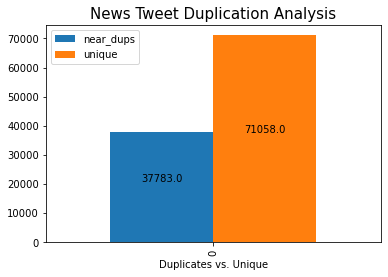

In [51]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('News Tweet Duplication Analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 